# Week 3 Assignment

🖊 Task



1.   Implement a simple generative AI model that recommends **fashion items** based on **user descriptions**.
2.   Integrate a basic reinforcement learning loop where user feedback (positive/negative) is used to adjust the recommendations.
3.   Process both **text** (e.g., user descriptions or item descriptions) and **image data** (e.g., item photos) to improve the recommendations.



❓Questions and Coding Tasks
1. Generative Model Setup
Implement a basic text-based generative model using GPT-2 or any other available language model. This model should take user input (a text description of their preferred style) and generate a list of recommended items. ***Coding Task:*** Write the code to load a pre-trained GPT-2 model or any other model, take a user input description (e.g., "casual outfit for summer"), and output three recommended items based on that input (can be a text or image, you can choose one of them).
2. Reinforcement Learning Loop
Implement a basic reinforcement learning loop where feedback (such as a "like" or "dislike") affects future recommendations. Use Q-learning or a similar approach to adjust recommendations based on feedback. ***Coding Task:*** Write a function that takes the feedback on generated recommendations (e.g., feedback = {"item1": 1, "item2": -1, "item3": 1}) and updates a Q-table or similar structure to refine the model"s recommendations (you can follow the method from our lesson Day-2)
3. Multi-Modal Data Integration (Optional, Bonus if you can answer this question) Enhance the recommendation by incorporating image data. Use a pre-trained image embedding model (e.g., CLIP, or any other model) to process item images and align them with user text descriptions for better accuracy.

# Install Libraries

In [1]:
!pip install torch -q transformers -q git+https://github.com/openai/CLIP.git -q
!pip install -U langchain-community -q
!pip install langchain_openai -q
!pip install langchain_core -q
!pip install langchain-google-genai -q
!pip install gym -q
!pip install openai -q
!pip install open-clip-torch -q
!pip install faiss-gpu -q
!pip install tqdm -q
!pip install -U google-generativeai -q

  Preparing metadata (setup.py) ... done


# Import Libraries

In [2]:
from google.colab import drive
drive.mount("/content/drive")
from google.colab import userdata

import os
import re  # For regular expressions to validate base64 format
import random
import numpy as np
import pandas as pd
import ipywidgets as widgets  # For creating interactive widgets in Jupyter Notebook
import base64  # For encoding images in base64 format
from IPython.display import display, HTML  # For displaying HTML content (e.g., images) in Jupyter notebooks
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ast

import pickle as pkl

from io import BytesIO

from PIL import Image

import gym
from gym import spaces

import torch
import clip
import openai

import faiss

from sklearn.preprocessing import normalize

import google.generativeai as genai

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/faiss/loader.py:28: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numpy.__version__) >= "1.19":
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/usr/local/lib/python3.10/dist-packages/google/colab/html/_background_server.py:103: DeprecationWarning: make_current is deprecated; start the event loop first
  ioloop.make_current()


# Load and Clean Dataset

In [3]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/iykra/Dataset W3/Dataset13/styles.csv", on_bad_lines="skip")
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


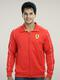

In [4]:
image_folder = "/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/"

# tes display image
image_path = os.path.join(image_folder, "1530.jpg")
img = Image.open(image_path)
display(img)

In [ ]:
print(df["masterCategory"].unique().tolist())
print(df["subCategory"].unique().tolist())
print(df["articleType"].unique().tolist())
print(df["baseColour"].unique().tolist())

In [5]:
uris = []

for index, row in df.iterrows():
  id = row["id"]

  uri = os.path.join(image_folder, f"{id}.jpg")
  uris.append(uri)

df["uri"] = uris
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,uri
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/content/drive/MyDrive/iykra/Dataset W3/Datase...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/content/drive/MyDrive/iykra/Dataset W3/Datase...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/content/drive/MyDrive/iykra/Dataset W3/Datase...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/content/drive/MyDrive/iykra/Dataset W3/Datase...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/content/drive/MyDrive/iykra/Dataset W3/Datase...
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,/content/drive/MyDrive/iykra/Dataset W3/Datase...
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,/content/drive/MyDrive/iykra/Dataset W3/Datase...
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,/content/drive/MyDrive/iykra/Dataset W3/Datase...
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks,/content/drive/MyDrive/iykra/Dataset W3/Datase...
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,/content/drive/MyDrive/iykra/Dataset W3/Datase...


In [6]:
df[df["productDisplayName"].isna()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,uri
3677,42878,Women,Accessories,Bags,Clutches,Maroon,Summer,2012.0,Casual,NaN,/content/drive/MyDrive/iykra/Dataset W3/Datase...
14291,30991,Women,Personal Care,Fragrance,Perfume and Body Mist,NaN,Spring,2017.0,NaN,NaN,/content/drive/MyDrive/iykra/Dataset W3/Datase...
17639,45687,Men,Personal Care,Fragrance,Perfume and Body Mist,NaN,Spring,2017.0,NaN,NaN,/content/drive/MyDrive/iykra/Dataset W3/Datase...
22089,42863,Women,Accessories,Bags,Clutches,Brown,Summer,2012.0,Casual,NaN,/content/drive/MyDrive/iykra/Dataset W3/Datase...
23484,45698,Women,Personal Care,Fragrance,Perfume and Body Mist,NaN,Spring,2017.0,NaN,NaN,/content/drive/MyDrive/iykra/Dataset W3/Datase...
37531,30992,Men,Personal Care,Fragrance,Perfume and Body Mist,NaN,Spring,2017.0,NaN,NaN,/content/drive/MyDrive/iykra/Dataset W3/Datase...
40675,43119,Men,Personal Care,Fragrance,Perfume and Body Mist,NaN,Spring,2017.0,NaN,NaN,/content/drive/MyDrive/iykra/Dataset W3/Datase...


In [7]:
df.fillna("", inplace=True)
df["year"] = df["year"].astype("str").str.replace(".0", "", regex=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-7-cf083ff90975>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("", inplace=True)


In [8]:
# Fill missing product display name
missing_name_df = df[df["productDisplayName"]==""].copy()
missing_name_df.fillna("",inplace=True)
missing_name_df["year"] = missing_name_df["year"].astype("str").str.replace(".0", "", regex=False)
missing_name_df["text"] = missing_name_df["gender"] +\
                          " " + missing_name_df["masterCategory"] +\
                          " " + missing_name_df["subCategory"] +\
                          " " + missing_name_df["articleType"] +\
                          " " + missing_name_df["baseColour"] +\
                          " " + missing_name_df["season"] +\
                          " " + missing_name_df["year"] +\
                          " " + missing_name_df["usage"] +\
                          " " + missing_name_df["productDisplayName"]

def generate_product_name(text_query="", image_query=""):
  GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY_1')
  genai.configure(api_key=GOOGLE_API_KEY)

  image = Image.open(image_query) if image_query else ""

  instruction = f"""
  You are fashion designer helping user create fashion product name using format like this:
  {df["productDisplayName"].iloc[0]}
  {df["productDisplayName"].iloc[1]}
  {df["productDisplayName"].iloc[2]}
  If there are several options, choose 1 while keeping the format. Don't give response outside format.
  """

  model = genai.GenerativeModel("gemini-1.5-flash-8b",
                                generation_config=genai.types.GenerationConfig(
                                  temperature=0.0,
                                  max_output_tokens=20,
                                  ),
                                system_instruction=instruction)

  response = model.generate_content([text_query, image])

  return response.text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
test_product_name = generate_product_name(missing_name_df["text"].iloc[0], missing_name_df["uri"].iloc[0])
test_product_name

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Summer Rhapsody Women Maroon Clutch\n'

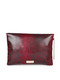

In [10]:
img = Image.open(missing_name_df["uri"].iloc[0])
display(img)

In [11]:
missing_name_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,uri,text
3677,42878,Women,Accessories,Bags,Clutches,Maroon,Summer,2012,Casual,,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Women Accessories Bags Clutches Maroon Summer ...
14291,30991,Women,Personal Care,Fragrance,Perfume and Body Mist,,Spring,2017,,,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Women Personal Care Fragrance Perfume and Body...
17639,45687,Men,Personal Care,Fragrance,Perfume and Body Mist,,Spring,2017,,,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Men Personal Care Fragrance Perfume and Body M...
22089,42863,Women,Accessories,Bags,Clutches,Brown,Summer,2012,Casual,,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Women Accessories Bags Clutches Brown Summer 2...
23484,45698,Women,Personal Care,Fragrance,Perfume and Body Mist,,Spring,2017,,,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Women Personal Care Fragrance Perfume and Body...
37531,30992,Men,Personal Care,Fragrance,Perfume and Body Mist,,Spring,2017,,,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Men Personal Care Fragrance Perfume and Body M...
40675,43119,Men,Personal Care,Fragrance,Perfume and Body Mist,,Spring,2017,,,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Men Personal Care Fragrance Perfume and Body M...


In [12]:
for idx, row in df.iterrows():
  if row["productDisplayName"]!="":
    continue

  text = row["gender"] +\
        " " + row["masterCategory"] +\
        " " + row["subCategory"] +\
        " " + row["articleType"] +\
        " " + row["baseColour"] +\
        " " + row["season"] +\
        " " + row["year"] +\
        " " + row["usage"] +\
        " " + row["productDisplayName"]
  print(idx)
  print(text)
  print(row["uri"])

  product_name = generate_product_name(text, row["uri"])
  df.at[idx, "productDisplayName"] = product_name

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3677
Women Accessories Bags Clutches Maroon Summer 2012 Casual 
/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/42878.jpg
14291
Women Personal Care Fragrance Perfume and Body Mist  Spring 2017  
/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/30991.jpg
17639
Men Personal Care Fragrance Perfume and Body Mist  Spring 2017  
/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/45687.jpg
22089
Women Accessories Bags Clutches Brown Summer 2012 Casual 
/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/42863.jpg
23484
Women Personal Care Fragrance Perfume and Body Mist  Spring 2017  
/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/45698.jpg
37531
Men Personal Care Fragrance Perfume and Body Mist  Spring 2017  
/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/30992.jpg
40675
Men Personal Care Fragrance Perfume and Body Mist  Spring 2017  
/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/43119.jpg


In [13]:
df[df["id"].isin(missing_name_df["id"])]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,uri
3677,42878,Women,Accessories,Bags,Clutches,Maroon,Summer,2012,Casual,Summer Rhapsody Women Maroon Clutch\n,/content/drive/MyDrive/iykra/Dataset W3/Datase...
14291,30991,Women,Personal Care,Fragrance,Perfume and Body Mist,,Spring,2017,,Spring Blossom Women Perfume\n,/content/drive/MyDrive/iykra/Dataset W3/Datase...
17639,45687,Men,Personal Care,Fragrance,Perfume and Body Mist,,Spring,2017,,Aqua Breeze Men Fragrance\n,/content/drive/MyDrive/iykra/Dataset W3/Datase...
22089,42863,Women,Accessories,Bags,Clutches,Brown,Summer,2012,Casual,Summer Breeze Women Brown Clutch\n,/content/drive/MyDrive/iykra/Dataset W3/Datase...
23484,45698,Women,Personal Care,Fragrance,Perfume and Body Mist,,Spring,2017,,Aura Rose Women Perfume\n,/content/drive/MyDrive/iykra/Dataset W3/Datase...
37531,30992,Men,Personal Care,Fragrance,Perfume and Body Mist,,Spring,2017,,John Varvatos Men Spring Breeze Perfume\n,/content/drive/MyDrive/iykra/Dataset W3/Datase...
40675,43119,Men,Personal Care,Fragrance,Perfume and Body Mist,,Spring,2017,,Atlas Men Amber Fragrance\n,/content/drive/MyDrive/iykra/Dataset W3/Datase...


In [14]:
df["productDisplayName"] = df["productDisplayName"].str.replace("\n", "", regex=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
df["text"] = df["gender"] +\
             " " + df["masterCategory"] +\
             " " + df["subCategory"] +\
             " " + df["articleType"] +\
             " " + df["baseColour"] +\
             " " + df["season"] +\
             " " + df["year"] +\
             " " + df["usage"] +\
             " " + df["productDisplayName"]
df.head(1)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,uri,text
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Men Apparel Topwear Shirts Navy Blue Fall 2011...


In [16]:
df["id"] = df["id"].astype("str")
df['text'] = df['text'].astype('str')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
img_list = []
img_dir = "/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images"

for i in os.listdir(img_dir):
  i = i.replace(".jpg", "")
  img_list.append(i)


df = df[df["id"].isin(img_list)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
df.reset_index(drop=True, inplace=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,uri,text
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Men Apparel Topwear Shirts Navy Blue Fall 2011...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Men Apparel Bottomwear Jeans Blue Summer 2012 ...
2,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Men Apparel Bottomwear Track Pants Black Fall ...
3,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Men Apparel Topwear Tshirts Grey Summer 2011 C...
4,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,/content/drive/MyDrive/iykra/Dataset W3/Datase...,Men Apparel Topwear Shirts Green Summer 2012 E...


# Create FAISS index for faster similarity search

I only use text description since embedding image takes forever to complete.

In [19]:
# Load the clip model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Create a function to change image to base64
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode("utf-8")

# Create a function to embed text
def embed_text(text):
  with torch.no_grad():
    tokens = clip.tokenize([text]).to(device)
    text_features = model.encode_text(tokens)
    return text_features.cpu().numpy().flatten()

# Create a function to embed image
def embed_image(image_path):
  image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
  with torch.no_grad():
    image_features = model.encode_image(image)
  return image_features.cpu().numpy().flatten()

In [21]:
text_embeddings = normalize(
  np.stack([embed_text(text) for text in tqdm(df["text"], desc="Embedding Text")]), axis=1
).astype("float32")

Embedding Text:   0%|          | 0/33765 [00:00<?, ?it/s]

In [22]:
# Build FAISS index
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)

chunk_size = 1000  # Customize based on your memory limits
for i in tqdm(range(0, len(text_embeddings), chunk_size), desc="Adding to FAISS Index"):
  chunk = text_embeddings[i:i + chunk_size]
  faiss_index.add(chunk)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Adding to FAISS Index:   0%|          | 0/34 [00:00<?, ?it/s]

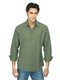

--------------------------------------


'Men Apparel Topwear Shirts Blue Fall 2011 Casual Probase Men Check Blue Shirts'

0.633307

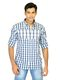

'Men Apparel Topwear Shirts Blue Fall 2011 Casual Probase Men Check Blue Shirts'

0.633307

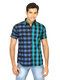

'Men Apparel Topwear Shirts Green Fall 2011 Casual Lee Men Check Green Shirts'

0.6307679

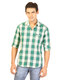

In [23]:
# Test similarity search
tes_text_query = "casual outfit"
tes_image_query = "/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/30805.jpg"

input_text_embeds = embed_text(tes_text_query)
input_image_embeds = embed_image(tes_image_query)

input_text_combined = normalize(
  0.5 * normalize(input_text_embeds.reshape(1, -1), axis=1)
  + 0.5 * normalize(input_image_embeds.reshape(1, -1), axis=1),
  axis=1
).astype("float32")

distances, indices = faiss_index.search(input_text_combined, k=3)

results = df.iloc[indices[0]]
display(Image.open(tes_image_query))
print("--------------------------------------")

for i in range(len(results)):
  display(results['text'].iloc[i])
  display(distances[0][i])
  display(Image.open(results["uri"].iloc[i]))

# Generative AI

In [51]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY_1')
genai.configure(api_key=GOOGLE_API_KEY)

def generate_query_faiss(text_query="", image_query=""):
  image = Image.open(image_query) if image_query else ""

  instruction = f"""
  You are a fashion expert responsible for understanding customer orders and translating them into detailed fashion product names in English for the warehouse team. You will process both user-provided descriptions and images to infer fashion product details. Your response must be accurate, concise, and follow the format below:

  ["fashion product name 1", "fashion product name 2", "fashion product name 3"]

  ### Requirements:
  1. Generate exactly 3 fashion product names, even if there is minimal input. Do not generate fewer or more than 3.
  2. Each fashion product name must include the **gender**, **color**, **usage (e.g., casual, formal, sporty)**, **types of fashion** and any **distinctive clothing characteristics** described by user.
  3. If the user specifies an attribute, fashion adjective or fashion noun in the text input, ensure it appears in all 3 fashion product names. Be creative in descriptions that is not in the text input or image input.
  4. Be attentive to clothes attribute: collar, neckline, sleeve, blouse, skirt, leg
  5. If both text and image are provided, use the text to modify the image context.
  """

  model = genai.GenerativeModel("gemini-1.5-flash-8b",
                                generation_config=genai.types.GenerationConfig(
                                  temperature=0.0,
                                  max_output_tokens=100,
                                  ),
                                system_instruction=instruction)

  if image_query and not text_query:
    response = model.generate_content([image, "I want clothes like this"])
  elif text_query and not image_query:
    response = model.generate_content([text_query])
  elif text_query and image_query:
    response = model.generate_content([image, text_query])
  else:
    text_query = "Any outfit, surprise me"
    response = model.generate_content([text_query])

  return response.text

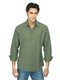

["Men's Olive Green Casual Shirt Outfit with Slim-Fit", "Men's Olive Green Casual Button-Down Shirt Outfit with Slim-Fit", "Men's Olive Green Casual Linen Shirt Outfit with Slim-Fit"]



In [25]:
# Tes query
tes_text_query = "casual outfit"
tes_image_query = "/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/30805.jpg"

display(Image.open(tes_image_query))
response = generate_query_faiss(tes_text_query, tes_image_query)
print(response)

In [26]:
# # Tes query
# tes_text_query = ""
# tes_image_query = "/content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/30805.jpg"

# response = generate_query_faiss(tes_text_query, tes_image_query)
# print(response)

In [27]:
# # Tes query
# tes_text_query = "Cari t-shirt casual warna biru lengan pendek untuk ke pantai"
# tes_image_query = ""

# response = generate_query_faiss(tes_text_query, tes_image_query)
# print(response)

In [28]:
# # Tes query
# tes_text_query = ""
# tes_image_query = ""

# response = generate_query_faiss(tes_text_query, tes_image_query)
# print(response)
# # response jika sudah dalam bentuk yang benar akan dimasukkan ke dalam ast.literal_eval

In [29]:
# def decode_image(b64image):
#   image = Image.open(BytesIO(b64image)).convert("RGB")
#   return np.array(image)

# Reinforcement Learning

In [30]:
df.loc[0, "productDisplayName"]

'Turtle Check Men Navy Blue Shirt'

In [31]:
# Define gym environment
# class FashionRecommendationEnv(gym.Env):
#   def __init__(self, products, num_users=1):
#     self.num_users = num_users
#     self.products = products
#     self.num_products = len(products)
#     self.action_space = spaces.Discrete(self.num_products)
#     self.observation_space = spaces.Discrete(num_users)
#     self.user = 0
#     self.state = self.user

#   def step(self, action, reward):
#     product = self.products[action]
#     reward = reward
#     done = True
#     return self.state, reward, done, {"product":product}

# Define Agent
class QLearningAgent:
  def __init__(self, products, alpha=0.1, gamma=0.9, epsilon=0.1):
    self.state = 0
    self.products = products
    self.q_table = pd.DataFrame([np.zeros(len(products), dtype=np.float32)], columns=products)
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon

  def update_q_table(self, action, reward):
    state = self.state
    max_future_q = np.max(self.q_table.loc[state])
    current_q = self.q_table.loc[state, action]
    new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)
    self.q_table.loc[state, action]= new_q

  def choose_action(self, table):
    if random.uniform(0, 1) < self.epsilon:
      return np.random.choice(table.columns.tolist())
    else:
      max_q = table.max()
      return np.random.choice(table.columns[table.eq(max_q).any()].tolist())

  def reset(self):
    self.state = 0
    self.q_table = pd.DataFrame([np.zeros(len(self.products), dtype=np.float32)], columns=self.products)

  def save_q_table(self, filename="q_table.pkl"):
    with open(filename, "wb") as f:
      pkl.dump(self.q_table, f)
    # print(f"Q-table saved tp {filename}.")

  def load_q_table(self, filename="q_table.pkl"):
    with open(filename, "rb") as f:
      self.q_table = pkl.load(f)
    # print(f"Q-table loaded from {filename}.")

# GenAi Recommend and RL Update preferences

In [58]:
def recommend_and_learn(agent):

  print("Selamat datang di toko kami! Mau cari apa?")
  print("----------------------------------------------------------------------------------")

  while True:
    exit_flag = False

    if exit_flag:
      break
    # Agent recommends a product
    text_query = input("Masukkan deskripsi produk yang ingin dicari. Kosongkan jika hanya ingin mencari dari gambar. Ketik 'exit' jika ingin keluar: ")
    if text_query.lower() == "exit":
      print("Terima kasih sudah berbelanja di toko kami!")
      break

    image_query = input("Masukkan link gambar produk yang ingin dicari. Kosongkan jika tidak ada. Ketik 'exit' jika ingin keluar: ")
    if image_query.lower() == "exit":
      print("Terima kasih sudah berbelanja di toko kami!")
      break

    # try:
    response = generate_query_faiss(text_query, image_query)
    response_list = ast.literal_eval(response)
    display_image = Image.open(image_query) if image_query else ""
    # except Exception as e:
    #   print(f"Maaf ada yang salah, coba lagi! Error:{e}")
    #   continue

    print("----------------------------------------------------------------------------------")
    print(f"Ini rekomendasi produk dari AI kami:\n{response}\n")
    print("Ini gambar produk yang kamu masukkan")
    display(display_image)
    print("----------------------------------------------------------------------------------")

    loop_starter = True

    while loop_starter:
      for text in response_list:
        if exit_flag:
          break

        input_text_embeds = embed_text(text)
        input_image_embeds = embed_image(image_query) if image_query else None

        if input_image_embeds is not None and input_text_embeds is not None:
          input_text_combined = normalize(
            0.5 * normalize(input_text_embeds.reshape(1, -1), axis=1)
            + 0.5 * normalize(input_image_embeds.reshape(1, -1), axis=1),
            axis=1
          ).astype("float32")
        elif input_text_embeds is not None:
          input_text_combined = normalize(
            input_text_embeds.reshape(1, -1), axis=1
          ).astype("float32")
        else:
          input_text_combined = normalize(
            input_text_embeds.reshape(1, -1), axis=1
          ).astype("float32")

        distances, indices = faiss_index.search(input_text_combined, k=30)

        results = df.iloc[indices[0]]
        result_id = results["id"].tolist()

        chosen_q_table = agent.q_table[result_id]

        action = agent.choose_action(chosen_q_table)

        action_series = results[results["id"]==action]

        recommended_image = action_series["uri"].values[0]
        recommended_name = action_series["productDisplayName"].values[0]

        display(Image.open(recommended_image))
        print("id:", action,",",recommended_name)

        while True:
          if exit_flag:
            break

          feedback = input("Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: ")

          if feedback.lower() == "yes":
            reward = 1
            print("Masuk ke keranjang!")
            agent.update_q_table(action, reward)
            break
          elif feedback.lower() == "no":
            reward = -4
            agent.update_q_table(action, reward)
            break
          elif feedback.lower() == "exit":
            print("Terima kasih sudah berbelanja di toko kami!")
            exit_flag = True
            break
          else:
            continue

          #Save Q-table after session
          agent.save_q_table()

      loop_check = input("Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: ")
      if loop_check.lower() == "exit":
        print("Terima kasih sudah berbelanja di toko kami!")
        exit_flag = True
        loop_starter = False
        break
      elif loop_check.lower() == "no":
        loop_starter = False
        break
      else:
        continue

# App demo

In [33]:
import warnings
warnings.filterwarnings("ignore")

Selamat datang di toko kami! Mau cari apa?
----------------------------------------------------------------------------------
Masukkan deskripsi produk yang ingin dicari. Kosongkan jika hanya ingin mencari dari gambar. Ketik 'exit' jika ingin keluar: Change the image color to light green. Keep every other image characterics.
Masukkan link gambar produk yang ingin dicari. Kosongkan jika tidak ada. Ketik 'exit' jika ingin keluar: /content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/30805.jpg
----------------------------------------------------------------------------------
Ini rekomendasi produk dari AI kami:
["Men's Light Green Casual Button-Down Shirt", "Men's Light Olive Green Long-Sleeve Formal Shirt", "Men's Light Sage Green Linen Casual Shirt"]


Ini gambar produk yang kamu masukkan


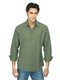

----------------------------------------------------------------------------------


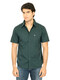

id: 19733 , United Colors of Benetton Men Solid Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


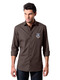

id: 37811 , John Players Men Olive Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


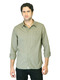

id: 22472 , Timberland Men Olive Claremont Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: no
Masukkan deskripsi produk yang ingin dicari. Kosongkan jika hanya ingin mencari dari gambar. Ketik 'exit' jika ingin keluar: Change the color to green. Keep every other characteristics.
Masukkan link gambar produk yang ingin dicari. Kosongkan jika tidak ada. Ketik 'exit' jika ingin keluar: /content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/30805.jpg
----------------------------------------------------------------------------------
Ini rekomendasi produk dari AI kami:
["Men's Olive Green Casual Button-Down Shirt", "Men's Forest Green Formal Long-Sleeve Shirt", "Men's Military Green Casual Linen Shirt"]


Ini gambar produk yang kamu masukkan


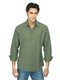

----------------------------------------------------------------------------------


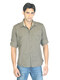

id: 32499 , Scullers Men Olive Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


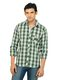

id: 17753 , Highlander Men Check Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


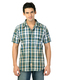

id: 12176 , Basics Men Green Slim Fit Checked Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


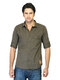

id: 29795 , Basics Men Olive Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


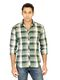

id: 16036 , Highlander Men Check Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


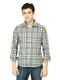

id: 22351 , John Players Men Check Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


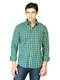

id: 23196 , Highlander Men Green Check Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


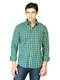

id: 23196 , Highlander Men Green Check Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


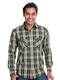

id: 2096 , Lee Men Olive Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


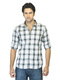

id: 29821 , Basics Men Green Checked Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


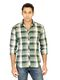

id: 16036 , Highlander Men Check Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


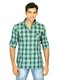

id: 12940 , Basics Men Green Slim Fit Checked Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


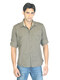

id: 32499 , Scullers Men Olive Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


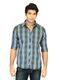

id: 16037 , Highlander Men Check Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


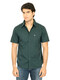

id: 19733 , United Colors of Benetton Men Solid Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


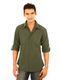

id: 11413 , United Colors of Benetton Men Olive Shirts
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


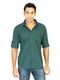

id: 15985 , Turtle Check Men Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


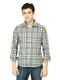

id: 22351 , John Players Men Check Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


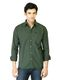

id: 23199 , Highlander Men Green Check Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


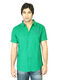

id: 24608 , Spykar Men Green Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


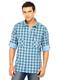

id: 11087 , Scullers Men Green Check Shirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: no
Masukkan deskripsi produk yang ingin dicari. Kosongkan jika hanya ingin mencari dari gambar. Ketik 'exit' jika ingin keluar: exit
Terima kasih sudah berbelanja di toko kami!


In [59]:
products = df["id"].tolist()

agent = QLearningAgent(products)
agent.reset()

recommend_and_learn(agent)
# /content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/30805.jpg

In [60]:
updated_q_table = agent.q_table.loc[:, (agent.q_table != 0).any()]
display(updated_q_table)

,22351,15985,23199,22472,23196,11413,19733,29795,12176,2096,37811,24608,17753,29821,32499,16036,11087,16037,12940
0,0.208718,-0.390111,0.118785,-0.4,-0.291216,0.109883,-0.750117,-0.391,-0.391,-0.390117,-0.4,-0.381215,0.1,-0.390117,-0.750117,-0.292017,0.118785,-0.390117,-0.390117


Selamat datang di toko kami! Mau cari apa?
----------------------------------------------------------------------------------
Masukkan deskripsi produk yang ingin dicari. Kosongkan jika hanya ingin mencari dari gambar. Ketik 'exit' jika ingin keluar: celana panjang warna coklat formal
Masukkan link gambar produk yang ingin dicari. Kosongkan jika tidak ada. Ketik 'exit' jika ingin keluar: 
----------------------------------------------------------------------------------
Ini rekomendasi produk dari AI kami:
["Women's Formal Brown Chinos", "Men's Formal Brown Dress Pants", "Unisex Formal Brown Trousers"]


Ini gambar produk yang kamu masukkan


''

----------------------------------------------------------------------------------


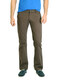

id: 16057 , Highlander Men Solid Brown Trouser
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


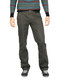

id: 16623 , Probase Men Solid Brown Trouser
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


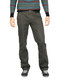

id: 16623 , Probase Men Solid Brown Trouser
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: no
Masukkan deskripsi produk yang ingin dicari. Kosongkan jika hanya ingin mencari dari gambar. Ketik 'exit' jika ingin keluar: celana panjang pria warna coklat formal
Masukkan link gambar produk yang ingin dicari. Kosongkan jika tidak ada. Ketik 'exit' jika ingin keluar: 
----------------------------------------------------------------------------------
Ini rekomendasi produk dari AI kami:
["Men's Formal Brown Chinos", "Men's Brown Formal Dress Pants", "Brown Formal Trousers for Men"]


Ini gambar produk yang kamu masukkan


''

----------------------------------------------------------------------------------


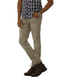

id: 44925 , Jack & Jones Men Brown Jeans
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


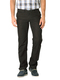

id: 29852 , Basics Men Dark Brown Trousers
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


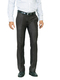

id: 14713 , Genesis Men Solid Brown Trousers
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


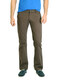

id: 16057 , Highlander Men Solid Brown Trouser
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


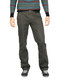

id: 16623 , Probase Men Solid Brown Trouser
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


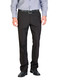

id: 39809 , Peter England Men Brown Trousers
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


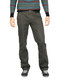

id: 16623 , Probase Men Solid Brown Trouser
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


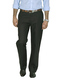

id: 39810 , Peter England Men Brown Formal Trousers
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


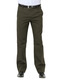

id: 10261 , John Miller Men Slim Brown Trousers
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: exit
Terima kasih sudah berbelanja di toko kami!
Masukkan deskripsi produk yang ingin dicari. Kosongkan jika hanya ingin mencari dari gambar. Ketik 'exit' jika ingin keluar: exit
Terima kasih sudah berbelanja di toko kami!


In [61]:
recommend_and_learn(agent)

In [62]:
updated_q_table = agent.q_table.loc[:, (agent.q_table != 0).any()]
display(updated_q_table)

,10261,22351,15985,44925,23199,29852,22472,16623,23196,14713,...,37811,24608,17753,29821,32499,39810,16036,11087,16037,12940
0,0.118785,0.208718,-0.390111,0.120312,0.118785,0.120312,-0.4,-0.540125,-0.291216,-0.379688,...,-0.4,-0.381215,0.1,-0.390117,-0.750117,0.118785,-0.292017,0.118785,-0.390117,-0.390117


Selamat datang di toko kami! Mau cari apa?
----------------------------------------------------------------------------------
Masukkan deskripsi produk yang ingin dicari. Kosongkan jika hanya ingin mencari dari gambar. Ketik 'exit' jika ingin keluar: 
Masukkan link gambar produk yang ingin dicari. Kosongkan jika tidak ada. Ketik 'exit' jika ingin keluar: /content/drive/MyDrive/iykra/Dataset W3/Dataset13/images/1530.jpg
----------------------------------------------------------------------------------
Ini rekomendasi produk dari AI kami:
["Men's Coral Red Casual Zip-Up Jacket", "Male Coral Red Sporty Zip-Up Jacket with Logo", "Man's Coral Red Track Jacket with Button Closure"]


Ini gambar produk yang kamu masukkan


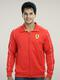

----------------------------------------------------------------------------------


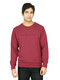

id: 19145 , United Colors of Benetton Men Solid Red SweatShirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


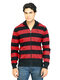

id: 18627 , Puma Men Striped Full Zip Red Sweaters
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


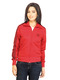

id: 19004 , ADIDAS Originals Women Firebird Red Jacket
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


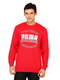

id: 18865 , Puma Men Red Sports Heritage Sweatshirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


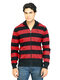

id: 18627 , Puma Men Striped Full Zip Red Sweaters
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


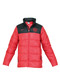

id: 17900 , Nike Men Football Soccer Red Jacket
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


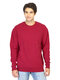

id: 19954 , United Colors of Benetton Men Red Sweater
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


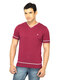

id: 19532 , United Colors of Benetton Men Solid Red Sweater
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


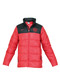

id: 17900 , Nike Men Football Soccer Red Jacket
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: yes


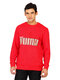

id: 18863 , Puma Men Heritage Red Sweatshirt
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no


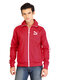

id: 16196 , Puma Men Heroes Red Jackets
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: yes
Masuk ke keranjang!


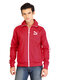

id: 16196 , Puma Men Heroes Red Jackets
Apakah ini yang kamu cari? (yes/no), Ketik 'exit' jika ingin keluar: no
Apakah kamu mau cari lagi dengan input yang sama? (yes/no), Ketik 'exit' jika ingin keluar: no
Masukkan deskripsi produk yang ingin dicari. Kosongkan jika hanya ingin mencari dari gambar. Ketik 'exit' jika ingin keluar: exit
Terima kasih sudah berbelanja di toko kami!


In [63]:
recommend_and_learn(agent)